# 

# Cumulative Probabilities

In [2]:
# Librerías

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import groupby
import copy
import os
from collections import Counter
from tqdm import tqdm

## Functions

In [3]:
# Loading the data

import os

base_sorted = r"C:\Users\HP\Desktop\PROYECTO UMAP\F4\ZENODO\Cumulative_Probability_Data\Sorted_Final"

def obtener_neuronas_por_area(base_sorted):
    datos = {"VPC": {"UMAP": [], "PCA": []},
             "DPC": {"UMAP": [], "PCA": []},
             "S2":  {"UMAP": [], "PCA": []}}

    for area in datos.keys():
        area_path = os.path.join(base_sorted, area)
        if not os.path.exists(area_path):
            continue

        for sesion in os.listdir(area_path):
            ses_path = os.path.join(area_path, sesion)
            if not os.path.isdir(ses_path):
                continue

            for electrodo in os.listdir(ses_path):
                e_path = os.path.join(ses_path, electrodo)
                if not os.path.isdir(e_path):
                    continue

                # buscar carpetas de sorted
                for metodo in ["sorted_UMAP", "sorted_PCA"]:
                    sorted_dir = os.path.join(e_path, metodo)
                    if not os.path.exists(sorted_dir):
                        continue

                    for file in os.listdir(sorted_dir):
                        if file.endswith(".csv"):
                            datos[area][metodo.split("_")[1]].append(os.path.join(sorted_dir, file))
    return datos

neuronas = obtener_neuronas_por_area(base_sorted)
print({k: {m: len(v) for m, v in v_.items()} for k, v_ in neuronas.items()})

{'VPC': {'UMAP': 228, 'PCA': 145}, 'DPC': {'UMAP': 129, 'PCA': 96}, 'S2': {'UMAP': 134, 'PCA': 60}}


In [4]:
EPS = 1e-9


def tasa_basal_umap(path_csv):
    df = pd.read_csv(path_csv)
    if df.empty or not {"Trial", "Spike Time"}.issubset(df.columns):
        return np.nan

    num_trials = df["Trial"].nunique()
    spikes_in_window = np.sum((df["Spike Time"] >= 0 - EPS) & (df["Spike Time"] < 0.5 - EPS))
    return spikes_in_window / (num_trials * 0.5)


def tasa_basal_pca(path_csv):
    df = pd.read_csv(path_csv)
    spike_cols = [c for c in df.columns if c.startswith("SpikeTime_")]
    if len(spike_cols) == 0 or df.empty:
        return np.nan
    trials_validos = 0
    spikes_in_window = 0
    for _, fila in df.iterrows():
        spikes = [fila[c] for c in spike_cols if pd.notna(fila[c])]
        if len(spikes) == 0:
            continue
        spikes = np.array(spikes, dtype=float)
        spikes_in_window += np.sum((spikes >= 0 - EPS) & (spikes < 0.5 - EPS))
        trials_validos += 1
    if trials_validos == 0:
        return np.nan
    return spikes_in_window / (trials_validos * 0.5)


def obtener_tasas_basales(neuron_paths, metodo):
    tasas = []
    for npath in tqdm(neuron_paths, desc=f"Calculando tasas ({metodo})"):
        try:
            tasa = tasa_basal_umap(npath) if metodo == "UMAP" else tasa_basal_pca(npath)
            if not np.isnan(tasa):
                tasas.append(tasa)
        except Exception as e:
            print(f"❌ Error en {npath}: {e}")
    return np.array(tasas)

In [5]:
# Ejemplo con VPC
tasas_vpc_umap = obtener_tasas_basales(neuronas["VPC"]["UMAP"], "UMAP")
tasas_vpc_pca  = obtener_tasas_basales(neuronas["VPC"]["PCA"],  "PCA")

Calculando tasas (PCA): 100%|██████████| 145/145 [00:28<00:00,  5.14it/s]


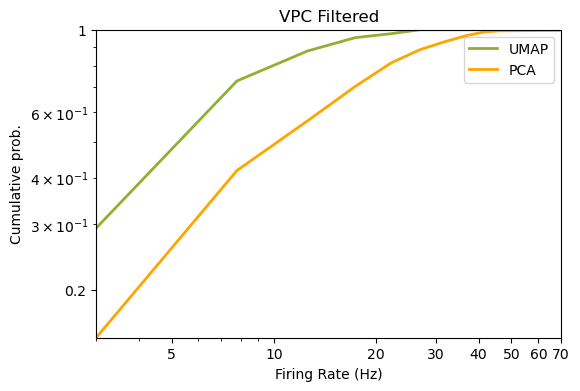

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Datos ordenados
datos_UMAP = np.sort(tasas_vpc_umap)
datos_PCA  = np.sort(tasas_vpc_pca)

# ECDF original
freq_UMAP = np.arange(1, len(datos_UMAP)+1) / len(datos_UMAP)
freq_PCA  = np.arange(1, len(datos_PCA)+1)  / len(datos_PCA)

# Parámetros
x_min = 3
x_max = 70
n_points = 15

# Rejilla común de X (lineal o la cambiamos a logspace si quieres)
x_common = np.linspace(x_min, x_max, n_points)

# Interpolar ECDF en rejilla común
y_UMAP = np.interp(x_common, datos_UMAP, freq_UMAP, left=np.nan, right=1)
y_PCA  = np.interp(x_common, datos_PCA,  freq_PCA,  left=np.nan, right=1)

# Valor ECDF real en x_min
y0_UMAP = np.interp(x_min, datos_UMAP, freq_UMAP)
y0_PCA  = np.interp(x_min, datos_PCA,  freq_PCA)

# Usar el menor para eje Y
y_start = min(y0_UMAP, y0_PCA)

# Graficar
plt.figure(figsize=(6,4))

plt.loglog(x_common, y_UMAP, lw=2, label="UMAP", color = "#8FB032")
plt.loglog(x_common, y_PCA, lw=2, label="PCA", color = "#FFA500")

# Etiquetas
plt.xlabel("Firing Rate (Hz)")
plt.ylabel("Cumulative prob.")
plt.title(f"VPC Filtered")

# Ticks personalizados
plt.xticks([5,10,20,30,40,50, 60, 70], ["5", "10", "20", "30", "40", "50", "60", "70"])

ax = plt.gca()

# ✅ Show only these major ticks + labels
ax.set_yticks([0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9 ,1.0])
ax.set_yticklabels(["0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9","1"])

# ✅ Major ticks fixed
ax.yaxis.set_major_locator(ticker.FixedLocator([0.2, 1.0]))

# ✅ Minor ticks: enable log minor ticks
# ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1))

# # ❌ Remove labels for minor ticks
# ax.yaxis.set_minor_formatter(ticker.NullFormatter())




# plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Límites
plt.xlim(x_min, x_max)
plt.ylim(y_start, 1)

plt.savefig("VPC.svg", format="svg", bbox_inches="tight", transparent=True)
plt.show()

# DPC

In [7]:
# Loading Data
tasas_dpc_umap = obtener_tasas_basales(neuronas["DPC"]["UMAP"], "UMAP")
tasas_dpc_pca  = obtener_tasas_basales(neuronas["DPC"]["PCA"],  "PCA")

Calculando tasas (PCA): 100%|██████████| 96/96 [00:27<00:00,  3.48it/s]


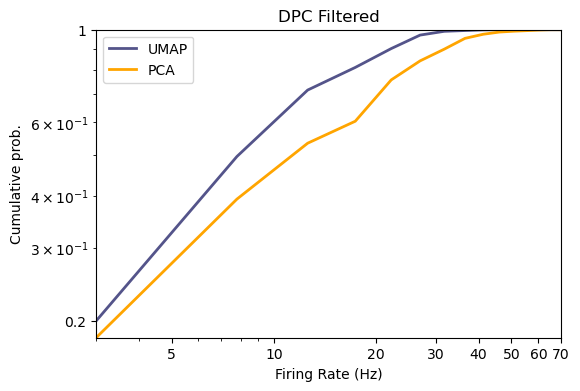

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Datos ordenados
datos_UMAP = np.sort(tasas_dpc_umap)
datos_PCA  = np.sort(tasas_dpc_pca)

# ECDF original
freq_UMAP = np.arange(1, len(datos_UMAP)+1) / len(datos_UMAP)
freq_PCA  = np.arange(1, len(datos_PCA)+1)  / len(datos_PCA)

# Parámetros
x_min = 3
x_max = 70
n_points = 15

# Rejilla común de X (lineal o la cambiamos a logspace si quieres)
x_common = np.linspace(x_min, x_max, n_points)

# Interpolar ECDF en rejilla común
y_UMAP = np.interp(x_common, datos_UMAP, freq_UMAP, left=np.nan, right=1)
y_PCA  = np.interp(x_common, datos_PCA,  freq_PCA,  left=np.nan, right=1)

# Valor ECDF real en x_min
y0_UMAP = np.interp(x_min, datos_UMAP, freq_UMAP)
y0_PCA  = np.interp(x_min, datos_PCA,  freq_PCA)

# Usar el menor para eje Y
y_start = min(y0_UMAP, y0_PCA)

# Graficar
plt.figure(figsize=(6,4))

plt.loglog(x_common, y_UMAP, lw=2, label="UMAP", color = "#54548A")
plt.loglog(x_common, y_PCA, lw=2, label="PCA", color = "#FFA500")

# Etiquetas
plt.xlabel("Firing Rate (Hz)")
plt.ylabel("Cumulative prob.")
plt.title(f"DPC Filtered")

# Ticks personalizados
plt.xticks([5,10,20,30,40,50, 60, 70], ["5", "10", "20", "30", "40", "50", "60", "70"])

ax = plt.gca()

# ✅ Show only these major ticks + labels
ax.set_yticks([0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9 ,1.0])
ax.set_yticklabels(["0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9","1"])


# ✅ Major ticks fixed
ax.yaxis.set_major_locator(ticker.FixedLocator([0.2, 1.0]))

# ✅ Minor ticks: enable log minor ticks
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1))

# # ❌ Remove labels for minor ticks
# ax.yaxis.set_minor_formatter(ticker.NullFormatter())




# plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Límites
plt.xlim(x_min, x_max)
plt.ylim(y_start, 1)

plt.savefig("DPC.svg", format="svg", bbox_inches="tight", transparent=True)
plt.show()

# S2

In [9]:
tasas_s2_umap = obtener_tasas_basales(neuronas["S2"]["UMAP"], "UMAP")
tasas_s2_pca  = obtener_tasas_basales(neuronas["S2"]["PCA"],  "PCA")

Calculando tasas (PCA): 100%|██████████| 60/60 [00:10<00:00,  5.83it/s]


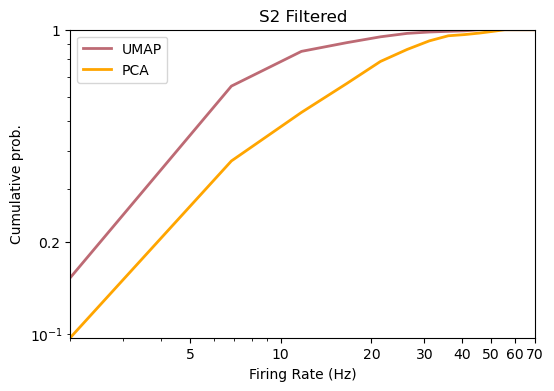

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Datos ordenados
datos_UMAP = np.sort(tasas_s2_umap)
datos_PCA  = np.sort(tasas_s2_pca)

# ECDF original
freq_UMAP = np.arange(1, len(datos_UMAP)+1) / len(datos_UMAP)
freq_PCA  = np.arange(1, len(datos_PCA)+1)  / len(datos_PCA)

# Parámetros
x_min = 2
x_max = 70
n_points = 15

# Rejilla común de X (lineal o la cambiamos a logspace si quieres)
x_common = np.linspace(x_min, x_max, n_points)

# Interpolar ECDF en rejilla común
y_UMAP = np.interp(x_common, datos_UMAP, freq_UMAP, left=np.nan, right=1)
y_PCA  = np.interp(x_common, datos_PCA,  freq_PCA,  left=np.nan, right=1)

# Valor ECDF real en x_min
y0_UMAP = np.interp(x_min, datos_UMAP, freq_UMAP)
y0_PCA  = np.interp(x_min, datos_PCA,  freq_PCA)

# Usar el menor para eje Y
y_start = min(y0_UMAP, y0_PCA)

# Graficar
plt.figure(figsize=(6,4))

plt.loglog(x_common, y_UMAP, lw=2, label="UMAP", color = "#BD6A74")
plt.loglog(x_common, y_PCA, lw=2, label="PCA", color = "#FFA500")

# Etiquetas
plt.xlabel("Firing Rate (Hz)")
plt.ylabel("Cumulative prob.")
plt.title(f"S2 Filtered")

# Ticks personalizados
plt.xticks([5,10,20,30,40,50, 60, 70], ["5", "10", "20", "30", "40", "50", "60", "70"])

ax = plt.gca()

# ✅ Show only these major ticks + labels
ax.set_yticks([0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9 ,1.0])
ax.set_yticklabels(["0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9","1"])

# ✅ Major ticks fixed
ax.yaxis.set_major_locator(ticker.FixedLocator([0.2, 1.0]))

# ✅ Minor ticks: enable log minor ticks
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1))

# # ❌ Remove labels for minor ticks
# ax.yaxis.set_minor_formatter(ticker.NullFormatter())




# plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Límites
plt.xlim(x_min, x_max)
plt.ylim(y_start, 1)

plt.savefig("S2.svg", format="svg", bbox_inches="tight", transparent=True)


plt.show()

# Cumulative Probabilites for all neurons

In [11]:
umap_neurons = np.concatenate((tasas_vpc_umap, tasas_dpc_umap, tasas_s2_umap))
pca_neurons = np.concatenate((tasas_vpc_pca, tasas_dpc_pca, tasas_s2_pca))

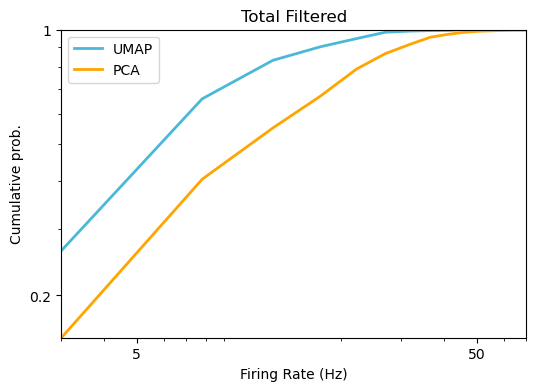

In [12]:
# Datos ordenados
datos_UMAP = np.sort(umap_neurons)
datos_PCA  = np.sort(pca_neurons)

# ECDF original
freq_UMAP = np.arange(1, len(datos_UMAP)+1) / len(datos_UMAP)
freq_PCA  = np.arange(1, len(datos_PCA)+1)  / len(datos_PCA)

# Parámetros
x_min = 3
x_max = 70
n_points = 15

# Rejilla común de X (lineal o la cambiamos a logspace si quieres)
x_common = np.linspace(x_min, x_max, n_points)

# Interpolar ECDF en rejilla común
y_UMAP = np.interp(x_common, datos_UMAP, freq_UMAP, left=np.nan, right=1)
y_PCA  = np.interp(x_common, datos_PCA,  freq_PCA,  left=np.nan, right=1)

# Valor ECDF real en x_min
y0_UMAP = np.interp(x_min, datos_UMAP, freq_UMAP)
y0_PCA  = np.interp(x_min, datos_PCA,  freq_PCA)

# Usar el menor para eje Y
y_start = min(y0_UMAP, y0_PCA)

# Graficar
plt.figure(figsize=(6,4))

plt.loglog(x_common, y_UMAP, lw=2, label="UMAP", color = "#4CB8D9")
plt.loglog(x_common, y_PCA, lw=2, label="PCA", color = "#FFA500")

# Etiquetas
plt.xlabel("Firing Rate (Hz)")
plt.ylabel("Cumulative prob.")
plt.title(f"Total Filtered")

# Ticks personalizados
plt.xticks([5, 50], ["5", "50"])

ax = plt.gca()

# ✅ Show only these major ticks + labels
ax.set_yticks([0.2, 1.0])
ax.set_yticklabels(["0.2", "1"])

# ✅ Major ticks fixed
ax.yaxis.set_major_locator(ticker.FixedLocator([0.2, 1.0]))

# ✅ Minor ticks: enable log minor ticks
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1))

# ❌ Remove labels for minor ticks
ax.yaxis.set_minor_formatter(ticker.NullFormatter())




# plt.grid(True, which="both", alpha=0.3)
plt.legend()

# Límites
plt.xlim(x_min, x_max)
plt.ylim(y_start, 1)

plt.savefig("Total.svg", format="svg", bbox_inches="tight", transparent=True)


plt.show()